<a href="https://colab.research.google.com/github/nrex-unibo/LassoDRT/blob/main/multi_file_GL-DRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

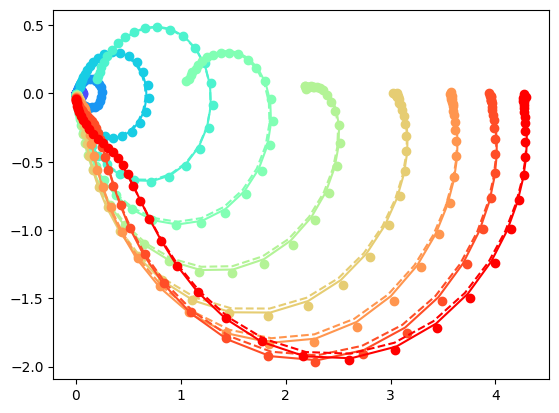

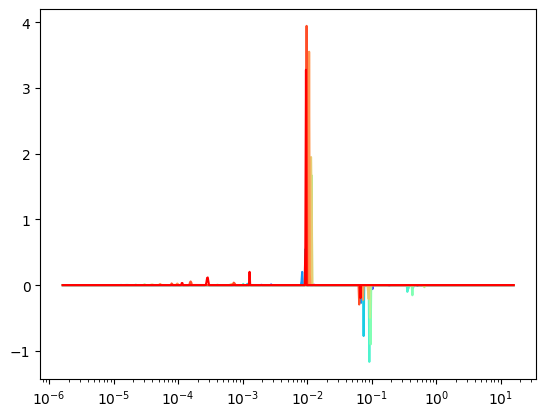

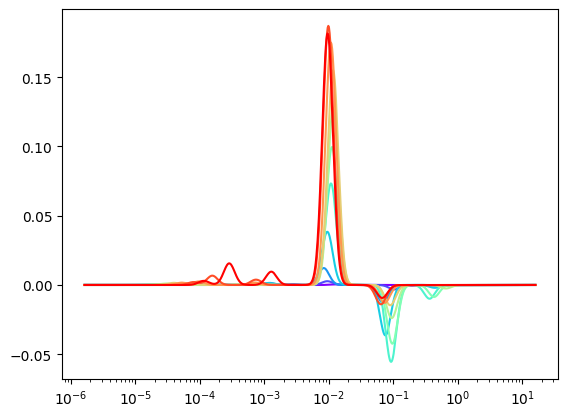

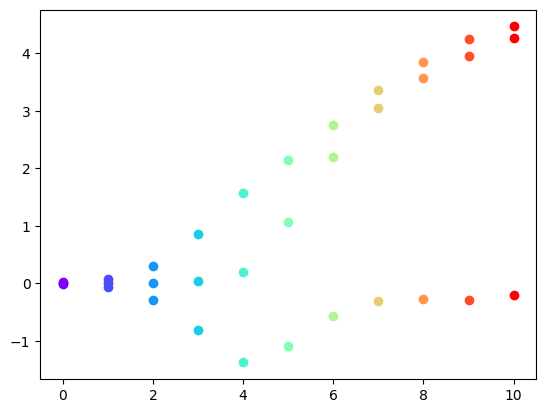

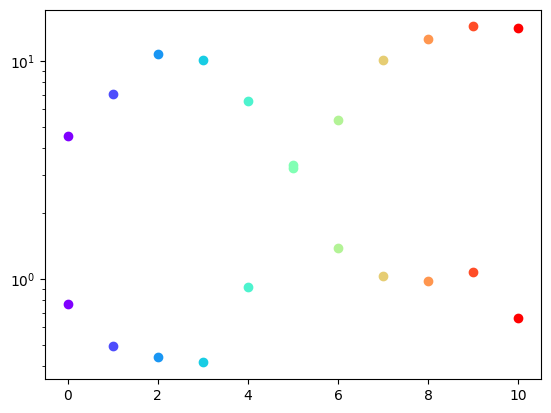

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import interpolate
import numpy.matlib
from matplotlib.pyplot import cm
from google.colab import files
import pandas as pd

def cvxpy_solve_qp(A1, A2, b1, b2, tau, lambda_value):
    """
        this function conducts the quadratic programming with cvxpy and
        output the optimum in numpy array format
    """
    N_out = tau.shape[0]
    x = cp.Variable(shape = N_out, value = np.ones(N_out))
    h = np.zeros(len(tau))
    prob = cp.Problem(cp.Minimize(cp.norm(b1 - A1 @ x) + cp.norm(b2 - A2 @ x) + lambda_value * cp.norm(x, 1)))

    prob.solve(solver=cp.SCS)
    gamma = x.value
    return gamma



def gaussian(tau, tau_c, A, sigma):
    return A*np.exp (-(np.log10(tau)-np.log10(tau_c))**2/(2*sigma**2))

n = 10
color=iter(cm.rainbow(np.linspace(0,1,n)))

# plotting results of the fit and of the DRT data as peaks and gaussian
fig1,ax1=plt.subplots()
fig2,ax2=plt.subplots()
fig3,ax3=plt.subplots()
fig4,ax4=plt.subplots()
fig5,ax5=plt.subplots()

for p in range(n):
  # import data from txt file and construct tau array
  # file needs to have frequency, real part and imaginary part in the first three columns
  filename = "/content/IMPS 5mW({})".format(p) # insert file name
  data = np.loadtxt(filename, skiprows = 1) # use skiprows to skip column names when importing data
  f = data[:,0]
  z_re = data[:, 1]
  z_im = -data[:, 2]
  f = f[::-1]
  z_re = z_re[::-1]
  z_im = z_im[::-1]
  omega = 2*np.pi*f
  tau = 1/omega
  # the considered characteristic times are logarithmically spaced and 10 times the experimental frequencies
  tau = np.logspace(np.log10(tau[0]),np.log10(tau[-1]),10*len(tau))
  # more tau values are added to expand the range of characteristic times used to fit the data
  tau = np.insert(tau,0,tau[0:100]*10)
  tau = np.append(tau,tau[-100:-1]/10)
  N = len(f)
  M = len(tau)

  # define the matrices
  A1 = np.zeros([N,M])
  A2 = np.zeros([N,M])

  for j in range(N):
    for k in range(M):
      A1[j,k] = (1/(1+omega[j]**2*tau[k]**2))
      A2[j,k] = (-(omega[j]*tau[k])/(1+omega[j]**2*tau[k]**2))

  # carry out the Lasso regularization
  g = cvxpy_solve_qp(A1, A2, z_re, z_im, tau, 0.5)

  # reconstructing the real and imaginary part using the values of g(tau)
  z_re_fit = np.zeros(N)
  z_im_fit = np.zeros(N)
  for j in range(N):
    for k in range(len(tau)):
      z_re_fit[j] += (g[k]/(1 + 1j*omega[j]*(tau[k]))).real
      z_im_fit[j] += (g[k]/(1 + 1j*omega[j]*(tau[k]))).imag

  # definition of the standard deviation used for the gaussian curves to build around each g(tau)
  sigma = 10*(np.log10(tau[1])-np.log10(tau[0]))/np.sqrt(2*np.log(2))
  g_gauss = np.zeros(len(tau))
  g_g = np.zeros(len(tau))

  for i in range(len(tau)):
    for j in range(len(tau)):
      g_g[j] = gaussian(tau[j], tau[i], g[i], sigma)
      g_gauss[j] += g_g[j]

  # normalization of the height of each gaussian
  area_peaks = np.trapz(y=g, x=np.log10(tau))
  area_gauss = np.trapz(y=g_gauss, x=np.log10(tau))

  g_gauss = g_gauss/area_gauss*area_peaks

  # reconstructing the real and imaginary part using the values of g_gauss(tau)
  z_re_fit_gauss = np.zeros(N)
  z_im_fit_gauss = np.zeros(N)
  for j in range(N):
    for k in range(len(tau)):
      z_re_fit_gauss[j] += (g_gauss[k]/(1 + 1j*omega[j]*(tau[k]))).real
      z_im_fit_gauss[j] += (g_gauss[k]/(1 + 1j*omega[j]*(tau[k]))).imag

  # calculating the Gartner current, the recombination current, and the total photocurrent 
  g_e=0;
  g_Gar=0;
  g_ph=0;
  g_w=0;

  for j in range(len(tau)):
    if g[j] < 0: 
      g_e = g_e + g[j] # recombination current
      g_w = g_w + g[j]*tau[j] # weighted average for calculating kt_meand and kr_mean
    if g[j] > 0: 
      g_Gar = g_Gar + g[j] # Gartner current

  g_ph = g_Gar + g_e # photocurrent

  tau_mean = g_w/g_e

  kt_mean = (g_ph/tau_mean)/g_Gar

  kr_mean = (1/tau_mean)-kt_mean

  c = next(color)

  ax1.plot(z_re,z_im,'o',z_re_fit,z_im_fit,z_re_fit_gauss,z_im_fit_gauss,'--', c=c)

  ax2.semilogx(tau, g, c=c)
  
  ax3.semilogx(tau, g_gauss, c=c)
  
  ax4.plot(p, g_e,'-o', p, g_Gar, '-o', p, g_ph, '-o', c=c)

  ax5.semilogy(p, kt_mean,'-o', p, kr_mean, '-o', c=c)

  # writing results on new files
  fileFIT = open("/content/FIT_{}.txt".format(p), "w")

  for i in range(len(z_re_fit)):
    print(z_re_fit[i], '\t', z_im_fit[i], file=fileFIT)

  fileFIT.close()

  fileDRT = open("/content/DRT_{}.txt".format(p), "w")

  for i in range(len(tau)):
    print(tau[i], '\t', g[i], file=fileDRT)

  fileDRT.close()

  fileFITGAUSS = open("/content/FIT_gauss_{}.txt".format(p), "w")

  for i in range(len(z_re_fit)):
    print(z_re_fit_gauss[i], '\t', z_im_fit_gauss[i], file=fileFITGAUSS)

  fileFITGAUSS.close()

  fileDRTGAUSS = open("/content/DRT_gauss_{}.txt".format(p), "w")

  for i in range(len(tau)):
    print(tau[i], '\t', g_gauss[i], file=fileDRTGAUSS)

  fileDRTGAUSS.close()

  fileJV = open("/content/JV.txt", "a")

  print(p, '\t', g_e, '\t', g_Gar, '\t', g_ph, '\t', kt_mean, '\t', kr_mean, file=fileJV)

  fileJV.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored